In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# 코호트 분석

## Summary

데이터 출처 : https://www.kaggle.com/jihyeseo/online-retail-data-set-from-uci-ml-repo   
고객 유입 월 별로 그룹을 만들어 해당 그룹의 지표의 변화 추이를 확인하였습니다. (지표 = 고객 매출)

0. 결과 분석 요약   

1. 데이터 전처리   
- 1) 누락제거   
- 2) 오류 확인   
- 3) 데이터 형변환

2. Cohort 표 제작
- 1) 각 구매 일자를 연/월 정보만 남김
- 2) 최초 구매 연/월 칼럼 제작
- 3) 고객 수 기준 Cohort 표 제작
- 4) 평균 고객 당 가치 기준 Cohort 표 제작

3. 결과 분석 요약

" 신규로 들어온 고객은 평균 소비금액이 낮고 월간 retention 도 낮다. (Retention : 월간 구매 활동 여부 기준 잔존 여부) "

- 2011년이 된 이후 유입한 고객의 retention 은 기존 대비 약 20% 로 기존 2010 년 12월 유입 고객 (35%) 에 비하면 매우 저조하다.
- 게다가 2011년 이 된 이후 유입된 고객의 인당 평균 구매액도 저조하다
    + 초반 유입 대비 줄어든 경우가 더 우세하고 (4월, 8월을 제외하고는 전부 초반 인평균 구매액 대비 줄어드는 경향을 보인다.)
    + 인당 평균 금액도 2010년 12월에는 700 이상이었으나, 그 외에는 2011년 5월을 제외하고 전부 600 이하 (주로 300수준) 이다.
    + 첫 월 대비 인당 구매 금액 증감율도 2011년에는 8월을 제외하고 1.2 이하로, 2010년 12월 (1.3)에 비해 10~30% 가량 악화되었다.

In [7]:
import os
path=os.getenv('HOME')+'/Base_DataScience/cohort/Online_Retail.xlsx'
df=pd.read_excel(path,   engine='openpyxl')

In [8]:
    
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


- InvoiceNo: 주문번호 (C로 시작할 경우 취소된 주문이다.)
- StockCode: 제품 코드. 각 제품별로 유니크하다.
- Quantity: 각 주문당 거래 제품 수
- InvoiceDate: 거래 시점 (주문번호가 생성된 시점)
- UnitPrice: 제품 개당 가격
- CustomerID: 각 고객 ID
- Country: 고객 거주 국가

# 1. 데이터 전처리 

- 데이터 누락 제거
- 데이터 오류 제거
- 데이터 형 변환


## 1) 누락 제거

In [11]:

df.isna().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [13]:
#Customer ID 를 알 수 없는 고객 표
#비회원 구매자는 54만 중 13만수준
#Retention을 알 수 없으므로 제거해야함
df[df.CustomerID.isna()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,2010-12-01 11:52:00,0.00,NaN,United Kingdom
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,2010-12-01 14:32:00,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,2010-12-01 14:32:00,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,2010-12-01 14:32:00,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,2011-12-09 10:26:00,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,2011-12-09 10:26:00,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,2011-12-09 10:26:00,10.79,NaN,United Kingdom


In [21]:
df=df.dropna(subset=['CustomerID'])

## 2) 오류 확인

In [24]:

df.describe()
#수량이 -80000인 경우 확인 필요

,Quantity,UnitPrice,CustomerID
count,406829.000000,406829.000000,406829.000000
mean,12.061303,3.460471,15287.690570
std,248.693370,69.315162,1713.600303
min,-80995.000000,0.000000,12346.000000
25%,2.000000,1.250000,13953.000000
50%,5.000000,1.950000,15152.000000
75%,12.000000,3.750000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [40]:
#취소 수량의 경우 수량이 -인 것으로 확인. 또한 취소되면서 동시에 기존 거래 내역도 사라진다. 
#따라서 수량이 0 이상인 거래 내역만 가지고 코호트 분석을 실행하면 허수(취소건)을 뺀, 순 거래건을 기준으로 정확한 지표를 뽑을 수 있다.
df[df.Quantity<0]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,2010-12-01 09:49:00,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,2010-12-01 10:24:00,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,2010-12-01 10:24:00,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,2011-12-09 09:57:00,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,2011-12-09 10:28:00,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,2011-12-09 11:57:00,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,2011-12-09 11:58:00,1.25,17315.0,United Kingdom


In [42]:
df=df[df.Quantity>0]
df

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France


## 3) 데이터 형 변환

In [43]:
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID            float64
Country                object
dtype: object

In [46]:
df.InvoiceNo=df['InvoiceNo'].astype(int)
df.Quantity=df['Quantity'].astype(int)
df.UnitPrice=df['UnitPrice'].astype(int)
df.CustomerID=df['CustomerID'].astype(int)

# 2. Cohort 표 제작

## 1) 각 구매일자를 구매 연/월 정보만 남김 (이후 월별로 고객 구매 금액 확인 할 것)

In [63]:
def month(transaction) : 
    return dt.datetime(transaction.year,transaction.month,1)
df['InvoiceMonth'] = df['InvoiceDate'].apply(month)


## 2) 최초 구매 연-월 칼럼 제작

In [64]:
grouping = df.groupby('CustomerID')['Month']

In [66]:
grouping.min()

CustomerID
12346   2011-01-01
12347   2010-12-01
12348   2010-12-01
12349   2011-11-01
12350   2011-02-01
           ...    
18280   2011-03-01
18281   2011-06-01
18282   2011-08-01
18283   2011-01-01
18287   2011-05-01
Name: InvoiceMonth, Length: 4339, dtype: datetime64[ns]

In [68]:
#최초 구매 월 : Init_Month
df['Init_Month'] = grouping.transform('min')

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,InvoiceMonth,CohortMonth,Init_Month
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2,17850,United Kingdom,2010-12-01,2010-12-01,2010-12-01
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3,17850,United Kingdom,2010-12-01,2010-12-01,2010-12-01
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2,17850,United Kingdom,2010-12-01,2010-12-01,2010-12-01
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3,17850,United Kingdom,2010-12-01,2010-12-01,2010-12-01
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3,17850,United Kingdom,2010-12-01,2010-12-01,2010-12-01


## 3) 고객 수 기준 Cohort 표 : 월별 구매를 진행한 고객의 Retention 

한번이라도 구매를 진행할 시 Active 하다고 판단   
각 월에 구매를 시작한 고객별로 묶어서 시간이 지날 수록 얼마나 이탈하는지 확인

In [74]:

df['Month_difference']=
(df['InvoiceMonth'].dt.month-df['Init_Month'].dt.month)+12*(df['InvoiceMonth'].dt.year-df['Init_Month'].dt.year)

In [85]:
df_customercount=df[['CustomerID', 'Init_Month','Month_difference']].drop_duplicates(subset=['CustomerID', 'Init_Month','Month_difference'])

In [88]:
#절대값 코호트 표 (한번이라도 구매가 있는 고객들을 맵핑)
abs_cohort_customercount=pd.pivot_table(df_customercount, index='Init_Month', columns='Month_difference', values="CustomerID", aggfunc='count')

In [89]:
abs_cohort_customercount

Month_difference,0,1,2,3,4,5,6,7,8,9,10,11,12
Init_Month,,,,,,,,,,,,,
2010-12-01,885.0,324.0,286.0,340.0,321.0,352.0,321.0,309.0,313.0,350.0,331.0,445.0,235.0
2011-01-01,417.0,92.0,111.0,96.0,134.0,120.0,103.0,101.0,125.0,136.0,152.0,49.0,NaN
2011-02-01,380.0,71.0,71.0,108.0,103.0,94.0,96.0,106.0,94.0,116.0,26.0,NaN,NaN
2011-03-01,452.0,68.0,114.0,90.0,101.0,76.0,121.0,104.0,126.0,39.0,NaN,NaN,NaN
2011-04-01,300.0,64.0,61.0,63.0,59.0,68.0,65.0,78.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,284.0,54.0,49.0,49.0,59.0,66.0,75.0,27.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,242.0,42.0,38.0,64.0,56.0,81.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,188.0,34.0,39.0,42.0,51.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,169.0,35.0,42.0,41.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


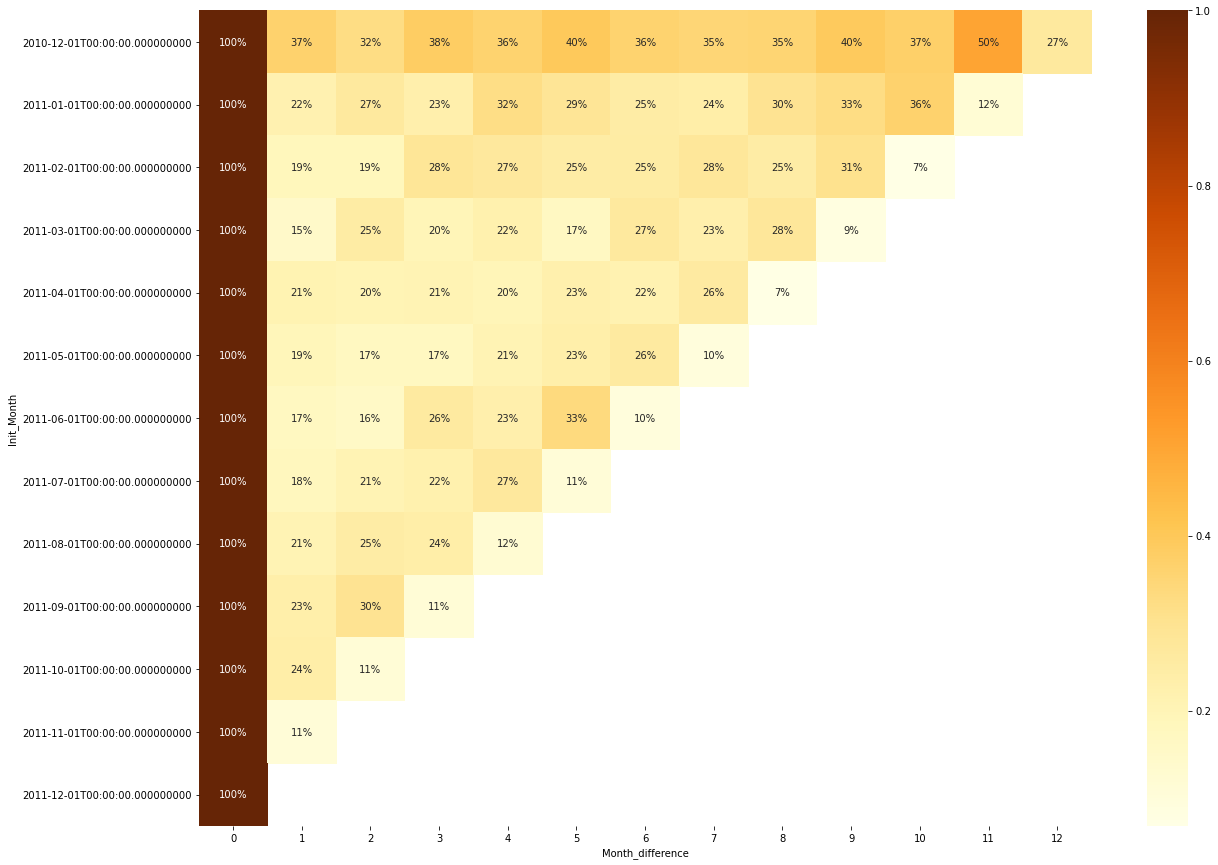

In [107]:
rel_cohort_customercount=abs_cohort_customercount.divide(abs_cohort_customercount.iloc[:,0], axis=0)
plt.figure(figsize=(20,15))
sns.heatmap(data=rel_cohort_customercount, annot=True, fmt='.0%', cmap="YlOrBr")
plt.show()

## 4) 고객 인당 구매금 기준 코호트

In [158]:
df['transaction_value']=df['UnitPrice']*df['Quantity']

In [159]:
df_customervalue=df[['CustomerID', 'Init_Month','Month_difference','transaction_value']]


In [180]:
df_customercount['Unique_val']=df_customercount.CustomerID.astype(str)+df_customercount.Month_difference.astype(str)

In [172]:
df_customervalue=pd.DataFrame(df_customervalue.groupby(['CustomerID', 'Month_difference']).sum()['transaction_value']).reset_index()

In [177]:
df_customervalue['Unique_val']=df_customervalue['CustomerID'].astype(str)+df_customervalue.Month_difference.astype(str)

In [182]:
df_customervalue

,CustomerID,Month_difference,transaction_value,Unique_val
0,12346,0,74215,123460
1,12347,0,560,123470
2,12347,1,282,123471
3,12347,4,486,123474
4,12347,6,274,123476
...,...,...,...,...
13050,18283,9,84,182839
13051,18283,10,428,1828310
13052,18283,11,152,1828311
13053,18287,0,536,182870


In [184]:
total_customer_value=pd.merge(df_customercount, df_customervalue)

In [189]:
#절대값 코호트 표 (인평균 구매액)
abs_cohort_customervalue=pd.pivot_table(total_customer_value, index='Init_Month', columns='Month_difference', values="transaction_value", aggfunc='mean')

Text(0.5, 1.0, 'Average customer value of each cohort group')

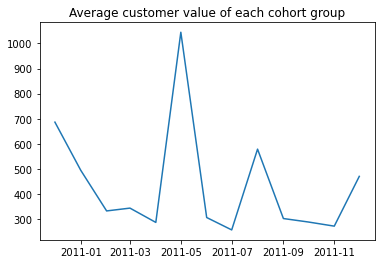

In [202]:
plt.plot(abs_cohort_customervalue.mean(axis=1))
plt.title('Average customer value of each cohort group')
#2011년 5월, 8월을 제외하고는 인당 평균 금액도 최근 구매 고객 일 수록 점차 감소하는 것을 확인 할 수 있다.

In [214]:
rel_cohort_customervalue=abs_cohort_customervalue.divide(abs_cohort_customervalue.iloc[:,0], axis=0)
#분석을 위해 특이치 제거
rel_cohort_customervalue.iloc[5,7]=1

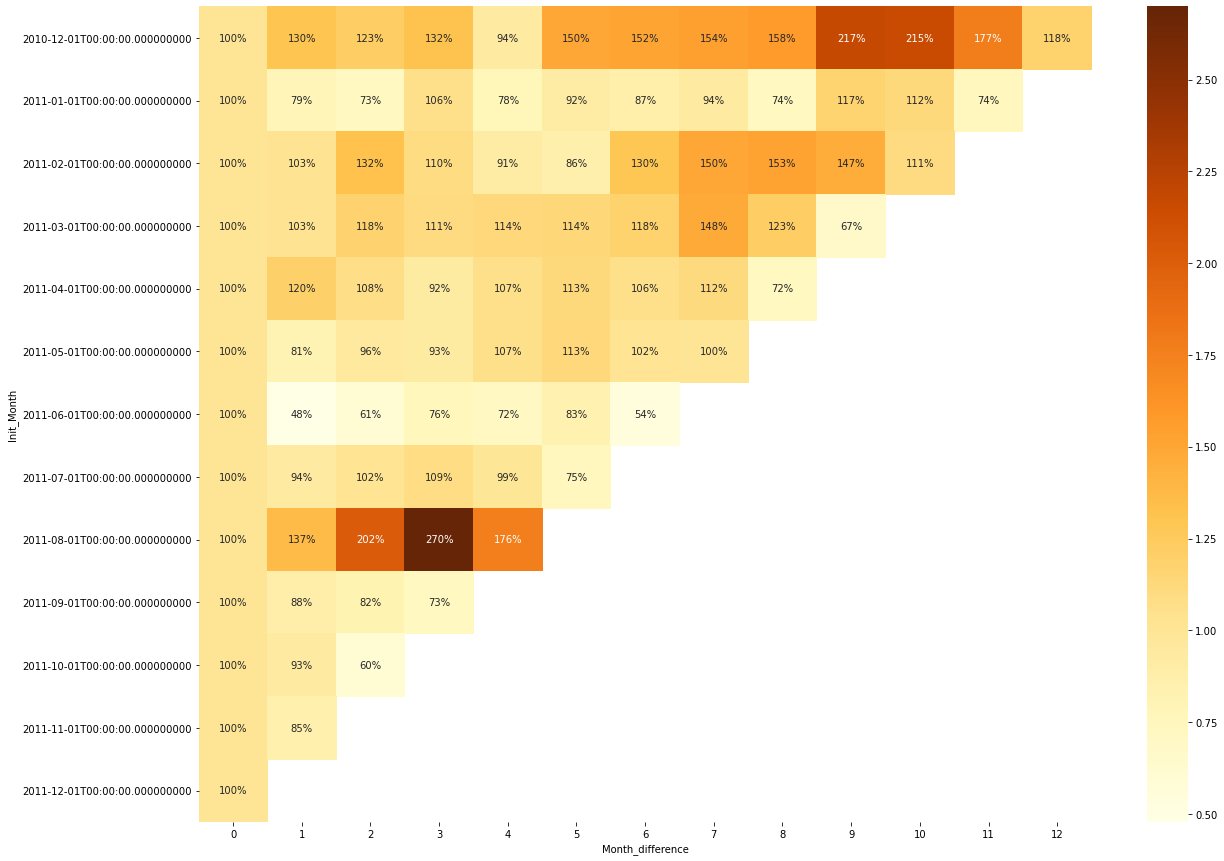

In [215]:
plt.figure(figsize=(20,15))
sns.heatmap(data=rel_cohort_customervalue, annot=True, fmt='.0%', cmap="YlOrBr")
plt.show()

Text(0.5, 1.0, 'average customer value increased of each cohort group')

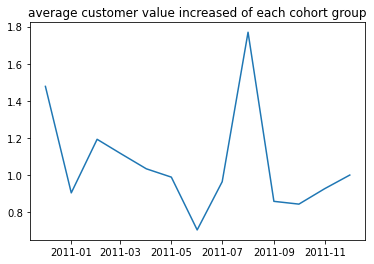

In [221]:
plt.figure()
plt.plot(rel_cohort_customervalue.mean(axis=1))
plt.title('average customer value increased of each cohort group')
#2011년 8월 그룹은 평균 1.8 배 가량 첫 월 대비 구매 금액이 증가 했다. 
#그러나 이 수치를 제외하고는 2011년 코호트 그룹은 첫월 대비 평균 구매 금액이 모두 1.2 이하로 2010년 12월 보다 급격히 감소했다.

# 4. 그래프 해석

### 1) 시간에 따른 전반적인 활동량

- 전체 월별 가입후 활동 고객의 평균을 냈을때 최신에 가입한 고객 그룹의 리텐션이 좋지 않음

[]

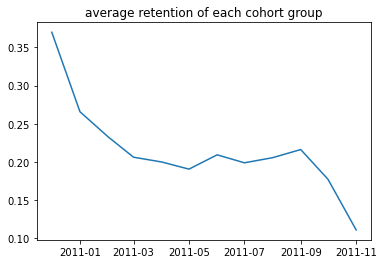

In [208]:
#각 코호트 그룹 별 평균 리텐션
#그래프를 보면 2010 년의 고객의 평균 리텐션은 30% 이상인데, 그 이후로는 점차 줄어드는 것으로 보임
plt.plot(rel_cohort_customercount.iloc[:,1:].mean(axis=1))
plt.title('average retention of each cohort group')
plt.plot()

### 2) First month, Second month 활동량

Text(0.5, 1.0, 'Retention of the first month for each cohort group')

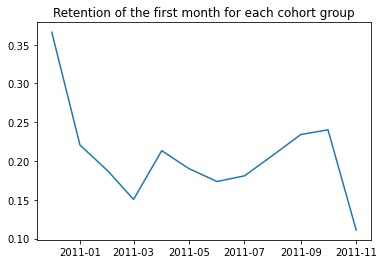

In [209]:
# 가입 후 첫 월 기준 retention 이 유지되는 고객의 비율은 2010 년 12월 가입 고객의 경우 30% 가 넘는데 비해 2011 년 에는 25% 를 넘지 못함
# 즉, firt month retention 부터 2011년 유입고객이 이전에 비해 확연히 악화되는 추세
plt.plot(rel_cohort_customercount.iloc[:,1])
plt.title('Retention of the first month for each cohort group')

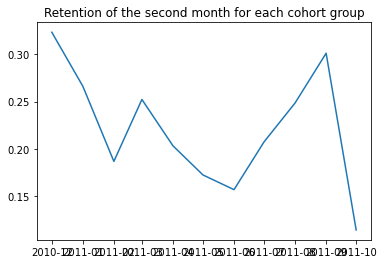

In [206]:
#그나마 2011년 9월 유입 고객의 활동성이 높은 편으로 보임
plt.plot(rel_cohort_customercount.iloc[:,2])
plt.title('Retention of the second month for each cohort group')
plt.show()

### 3) Last two months 활동량|
- 현재의 매출과 가장 연관이 높은 최근 2달 기준으로도 retention 은 2011년 직후 악화 되었다가 점차 회복하는 중이다. 

In [150]:
# 이전 월 기준
lastmonth=[]
for i in range(11):
    lastmonth.append(rel_cohort_customercount.iloc[i,12-i])

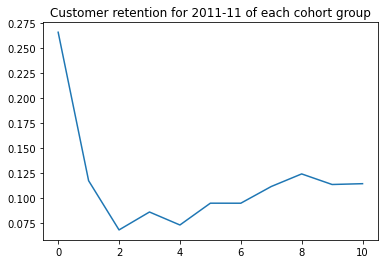

In [204]:
plt.plot(lastmonth)
plt.title('Customer retention for 2011-11 of each cohort group')
plt.show()
#2011년 2월이 가장 낮고 이후로 조금씩 향상되는 중